# ---------Smartphone-Based Digital Phenotyping----------

### Predicting the type of physical activity (e.g., walking, climbing stairs) from tri-axial smartphone accelerometer data.

    Physical activity categories:
            1 = standing
            2 = walking
            3 = stairs down
            4 = stairs

    
    Approach:
        Since this is a classification problem, models that aid in classification will be used.


## Import libraries

In [69]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import time
from datetime import datetime

from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pd.options.display.max_rows = 999

## Load data
    4 csv files --> train_time_series, train_labels, test_time_series, test_labels

In [70]:
#Start time
start_time = time.time()

In [71]:
#Read in training and testing csv files
train_data = pd.read_csv('train_time_series.csv')
train_labels = pd.read_csv('train_labels.csv')

test_data = pd.read_csv('test_time_series.csv')
test_labels = pd.read_csv('test_labels.csv')

In [72]:
# #drop 'Unnamed: 0' first column in all df
train_labels = train_labels.drop(columns = 'Unnamed: 0')
train_data = train_data.drop(columns = 'Unnamed: 0')   #dataset

test_labels = test_labels.drop(columns = 'Unnamed: 0')
test_data = test_data.drop(columns = 'Unnamed: 0')

# Summarize the Dataset

In [73]:
print("Train Time Series dimensions: ", train_data.shape)
print("Train Labels dimensions: ",train_labels.shape, "\n")
print("Test Time Series dimensions: ",test_data.shape)
print("Test Labels dimensions: ",test_labels.shape)

Train Time Series dimensions:  (3744, 6)
Train Labels dimensions:  (375, 3) 

Test Time Series dimensions:  (1250, 6)
Test Labels dimensions:  (125, 3)


In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3744 entries, 0 to 3743
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3744 non-null   int64  
 1   UTC time   3744 non-null   object 
 2   accuracy   3744 non-null   object 
 3   x          3744 non-null   float64
 4   y          3744 non-null   float64
 5   z          3744 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 175.6+ KB


In [75]:
train_data.head()

,timestamp,UTC time,accuracy,x,y,z
0,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450


In [76]:
train_labels.head()

,timestamp,UTC time,label
0,1565109931087,2019-08-06T16:45:31.087,1
1,1565109932090,2019-08-06T16:45:32.090,1
2,1565109933092,2019-08-06T16:45:33.092,1
3,1565109934094,2019-08-06T16:45:34.094,1
4,1565109935097,2019-08-06T16:45:35.097,1


# Statistical Summary

### Multivariate plots (scatter matrix) for x, y, z

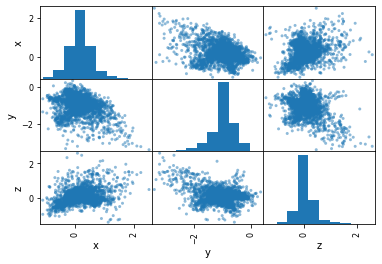

In [77]:
#scatter plot matrix
scatter_matrix(train_data[['x', 'y', 'z']])
plt.show();

x, y and z are slightly skewed, but generally have a normal distribution.

# Combining  train_data and train_labels
    Df reduced to 375 known features with outcomes

In [78]:
#Create an empty column aka zero valued column in "train_data" dataframe called 'label'
train_data['label'] = pd.Series(np.zeros(len(train_data)))

#Find intersecting timestamp indices
xy, x_ind, y_ind = np.intersect1d(np.array(train_data.timestamp), np.array(train_labels.timestamp), return_indices=True)
print(xy, x_ind, y_ind) 
## "xy" is an np.array which consists of the matching timestamp btw train_labels and train_data
## "x_ind" is an np.array which consists of the indices of train_data which have matching timestamps with the train_labels
## "y_ind" is an np.array which consists of the indices of train_labels which have matching timestamps with the train_data

[1565109931087 1565109932090 1565109933092 1565109934094 1565109935097
 1565109936099 1565109937101 1565109938103 1565109939106 1565109940108
 1565109941110 1565109942113 1565109943115 1565109944117 1565109945119
 1565109946122 1565109947124 1565109948126 1565109949129 1565109950131
 1565109951133 1565109952136 1565109953138 1565109954140 1565109955142
 1565109956145 1565109957147 1565109958149 1565109959152 1565109960154
 1565109961156 1565109962158 1565109963161 1565109964163 1565109965165
 1565109966168 1565109967170 1565109968172 1565109969175 1565109970177
 1565109971179 1565109972181 1565109973184 1565109974186 1565109975188
 1565109976191 1565109977193 1565109978195 1565109979197 1565109980200
 1565109981202 1565109982204 1565109983207 1565109984209 1565109985211
 1565109986213 1565109987216 1565109988218 1565109989220 1565109990223
 1565109991225 1565109992227 1565109993229 1565109994232 1565109995234
 1565109996236 1565109997239 1565109998241 1565109999243 1565110000246
 15651

In [79]:
## Assigning the "label" values of "train_labels" dataframe to the zeroed "label" column 
## of "train_data" dataframe

for i in range(len(x_ind)):
    train_data.label.iloc[x_ind[i]] = train_labels.label.iloc[y_ind[i]]

/home/b_cass_/anaconda3/envs/cv2_conda/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [80]:
#"train_data" with the correct labels taken from the "train_labels"

train_data.head()

,timestamp,UTC time,accuracy,x,y,z,label
0,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046,0.0
1,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554,0.0
2,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467,0.0
3,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985,1.0
4,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450,0.0


In [81]:
#"train_data" with the correct labels taken from the "train_labels"

train_data.tail() 

,timestamp,UTC time,accuracy,x,y,z,label
3739,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304,0.0
3740,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213,0.0
3741,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713,0.0
3742,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805,0.0
3743,1565110306039,2019-08-06T16:51:46.039,unknown,0.689346,-0.991043,0.034973,4.0


In [82]:
train_data.label.value_counts()

0.0    3369
2.0     213
3.0      88
4.0      47
1.0      27
Name: label, dtype: int64

In [83]:
train_labels.label.value_counts()

2    213
3     88
4     47
1     27
Name: label, dtype: int64

All labels from train_label df have been successfully added to train_data. 

### Splitting "train_data" dataframe (with labels) into train & validation arrays

In [84]:
## Capture non-zero label values in new dataframe. 
## New dataframe now has 375 rows.
train_data_withlabels = train_data[train_data.label !=0]   

#Further reducing dataframe to include only independent and dependent variables
train_data_withlabels = train_data_withlabels.drop(columns = ['timestamp','accuracy', 'UTC time'])  #drop 'accuracy' & 'UTC' columns
train_data_withlabels

,x,y,z,label
3,-0.053802,-0.987701,0.068985,1.0
13,0.013718,-0.852371,-0.000870,1.0
23,0.145584,-1.007843,-0.036819,1.0
33,-0.099380,-1.209686,0.304489,1.0
43,0.082794,-1.001434,-0.025375,1.0
53,0.037582,-0.998383,0.019333,1.0
63,-0.020554,-0.999741,0.120789,1.0
73,0.032440,-0.970337,0.241425,1.0
83,0.212524,-0.976364,0.074997,1.0
93,0.154510,-0.843460,0.010544,2.0


In [85]:
train_data_withlabels.label.value_counts()

2.0    213
3.0     88
4.0     47
1.0     27
Name: label, dtype: int64

In [86]:
train_data_withlabels.shape

(375, 4)

In [87]:
#Splitting data into train / validation set
array = train_data_withlabels.values
X = array[:, 0:3]  #X is equals to x, y, z from the dataframe
y = array[:, 3] #y is the label from the datframe which is at the last of the dataframe
X_train, X_validation, Y_train, Y_validation = train_test_split(X,y, test_size = 0.1, random_state = 1)

In [88]:
print("X_train_data shape ", X_train.shape)
print("Y_train_labels shape ", Y_train.shape)

print("\nX_validation_data shape ", X_validation.shape)
print("Y_validation_labels shape ", Y_validation.shape)

X_train_data shape  (337, 3)
Y_train_labels shape  (337,)

X_validation_data shape  (38, 3)
Y_validation_labels shape  (38,)


## Methods: Build Models
    Testing 7 different algorithms:

    Logistic Regression (LR)
    Linear Discriminant Analysis (LDA)
    K-Nearest Neighbors (KNN).
    Classification and Regression Trees (CART).
    Gaussian Naive Bayes (NB).
    Support Vector Machines (SVM).
    RandomForestClassifier(RF)

In [89]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('RF', RandomForestClassifier()))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle = True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.563904 (0.020155)
LDA: 0.560873 (0.020422)
KNN: 0.566845 (0.054322)
RF: 0.564082 (0.044889)


Three models seem to be best - SVM, KNN, RF

### Comparing model prediction power on X_validation set using SVM, KNN, RF 

In [90]:

#NOW WE WILL USE ONLY SELECTED 3 MODELS 
reduced_models = []

reduced_models.append(('KNN-----', KNeighborsClassifier()))
reduced_models.append(('RF-----', RandomForestClassifier()))

def modelpred_power(X_train, Y_train, X_validation, models):
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_validation)
        
        #Evaluate predictions on Y_validation data set
        print("\n", name, " ", accuracy_score(Y_validation, predictions))
        print(confusion_matrix(Y_validation, predictions))
        print(classification_report(Y_validation, predictions))

In [91]:
modelpred_power(X_train, Y_train, X_validation, reduced_models)


 KNN-----   0.6052631578947368
[[ 4  0  0  0]
 [ 1 16  2  1]
 [ 0  7  2  0]
 [ 0  4  0  1]]
              precision    recall  f1-score   support

         1.0       0.80      1.00      0.89         4
         2.0       0.59      0.80      0.68        20
         3.0       0.50      0.22      0.31         9
         4.0       0.50      0.20      0.29         5

    accuracy                           0.61        38
   macro avg       0.60      0.56      0.54        38
weighted avg       0.58      0.61      0.56        38


 RF-----   0.5526315789473685
[[ 4  0  0  0]
 [ 0 15  2  3]
 [ 0  8  1  0]
 [ 0  4  0  1]]
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         4
         2.0       0.56      0.75      0.64        20
         3.0       0.33      0.11      0.17         9
         4.0       0.25      0.20      0.22         5

    accuracy                           0.55        38
   macro avg       0.53      0.52      0.51        38


KNN has highest accuracy score (60%) on X_validation data. Also has highest precision for labels 2 and 3 which would likely have highest frequency in predictions.

# Results : Predicting on test_data with KNN classifier

In [92]:
#Using KNN model to make predictions on test_data df
model = KNeighborsClassifier()

#Fit the model on X_train, Y_train
model.fit(X_train, Y_train)
table_predictions = model.predict(test_data[['x', 'y', 'z']].values)

In [93]:
len(table_predictions)
test_labels

,timestamp,UTC time,label
0,1565110307041,2019-08-06T16:51:47.041,NaN
1,1565110308043,2019-08-06T16:51:48.043,NaN
2,1565110309046,2019-08-06T16:51:49.046,NaN
3,1565110310048,2019-08-06T16:51:50.048,NaN
4,1565110311050,2019-08-06T16:51:51.050,NaN
5,1565110312045,2019-08-06T16:51:52.045,NaN
6,1565110313047,2019-08-06T16:51:53.047,NaN
7,1565110314049,2019-08-06T16:51:54.049,NaN
8,1565110315051,2019-08-06T16:51:55.051,NaN
9,1565110316054,2019-08-06T16:51:56.054,NaN


In [94]:
#Append table_predictions onto test_data df
test_data['labels'] = pd.Series(table_predictions)

In [95]:
test_data.head()

,timestamp,UTC time,accuracy,x,y,z,labels
0,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623,3.0
1,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975,2.0
2,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771,3.0
3,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810,2.0
4,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550,2.0


In [96]:
#Find intersecting timestamp values from train_data and train_Labels
xy, x_ind, y_ind = np.intersect1d(np.array(test_data.timestamp), np.array(test_labels.timestamp), return_indices=True)

# Reduced test_data with predictions
prediction_table = test_data.iloc[x_ind]
prediction_table = prediction_table.reset_index(drop = True)

In [97]:
prediction_table

,timestamp,UTC time,accuracy,x,y,z,labels
0,1565110307041,2019-08-06T16:51:47.041,unknown,0.098282,-0.833771,0.118042,2.0
1,1565110308043,2019-08-06T16:51:48.043,unknown,0.348465,-0.946701,-0.051041,2.0
2,1565110309046,2019-08-06T16:51:49.046,unknown,0.377335,-0.849243,-0.026474,2.0
3,1565110310048,2019-08-06T16:51:50.048,unknown,0.110077,-0.520325,0.312714,2.0
4,1565110311050,2019-08-06T16:51:51.050,unknown,0.283478,-0.892548,-0.085876,3.0
5,1565110312045,2019-08-06T16:51:52.045,unknown,0.039337,-1.075836,-0.259964,2.0
6,1565110313047,2019-08-06T16:51:53.047,unknown,0.102356,-0.245255,0.228683,3.0
7,1565110314049,2019-08-06T16:51:54.049,unknown,0.342072,-1.051315,-0.007614,2.0
8,1565110315051,2019-08-06T16:51:55.051,unknown,0.432999,-0.910416,0.046341,2.0
9,1565110316054,2019-08-06T16:51:56.054,unknown,0.204208,-0.918640,-0.009323,2.0


In [98]:
predictions  = pd.Series(np.array(prediction_table.labels))
predictions.to_csv("my_predictions.csv", index = False)

In [99]:
prediction_table.labels.value_counts()

2.0    79
1.0    23
3.0    22
4.0     1
Name: labels, dtype: int64

In [100]:
end_time = time.time()

In [101]:
time_diff = end_time - start_time

In [102]:
print(time_diff)

10.874945163726807


## CONCLUSION:

    Although the KNN model offers only 61% accuracy on the X_validation set, it reflects that people in the test dataset 
    prefer activities in the following order:
    
    Walking
    Standing
    Stairs Down
    Stairs (up)
    